In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import sys

import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *

from constants import *
import equations
import redshiftPrior

In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 24
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
def calculate_total_rate(priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    return total_sum

def calculate_expected_num_events(T_obs, priors):
    '''
    T_obs : float
        observation time (in seconds)
    priors: bilby.core.prior.PriorDict
        bilby prior dictionary

    Returns:
    --------
    N : float
        Expected number of events in that time
    '''
    rate = calculate_total_rate(priors)
    return T_obs * rate

def get_weights(dEdfs, reference_priors, target_priors, zs, m1s, qs):
    """
    get weights that we use to reweight our spectrum
    
    dEdfs : array-like
        array of h+^2 + hx^2 for the reference injectionset
    reference_priors : bilby.core.prior.PriorDict
        bilby prior dictionary for the reference priors
    target_priors : bilby.core.prior.PriorDict
        bilby prior dictionary for the target priors we want to use to calculate Omega_gw
    zs : array-like
        redshift of each injection
    m1s : array-like
        mass1s of each injection
    m2s : array-like
        mass2s of each injection
    qs : mass ratios of each injection
    
    """
    weights = []
    for i in range(N_inj):
        z = zs[i]
        m1 = m1s[i]
        # m2 = m2s[i]
        q = qs[i]
        # Mtot = Mtots[i]
        # M = Ms[i]

        # Probability of drawing {z, m1, m2}
        p_z = target_priors['redshift'].prob(z)
        p_m1 = target_priors['mass_1'].prob(m1)
        p_q = target_priors['mass_ratio'].prob(q)

        pdraw_z = reference_priors['redshift'].prob(z)
        pdraw_m1 = reference_priors['mass_1'].prob(m1)
        pdraw_q = reference_priors['mass_ratio'].prob(q)

        # # Weight calculation
        # r = equations.R_SI(alpha, beta, z, zp, R0)
        # h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
        h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

        wi = (p_z/pdraw_z) * (p_m1/pdraw_m1) * (p_q/pdraw_q)
        weights.append(wi)
    return np.array(weights)

# Define some parameters

In [4]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = 0.1 # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
sampling_frequency = 1024 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

N_inj = 100_000 # number of injections that we will then reweight

# Set up prior dictionary for $\Omega_{gw}(f)$

This is the prior dictionary that we want to calculate $Omega_{gw}(f)$ for eventually

In [5]:
# Prior dictionary for priors we *want* to calculate omega_gw for
target_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
target_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
target_priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
target_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
target_priors['chi_1'] = 0
target_priors['chi_2'] = 0
target_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
target_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del target_priors['luminosity_distance']
del target_priors['chirp_mass']

11:34 bilby INFO    : Using aligned spin prior
11:34 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


# Set up reference prior dictionary

Here we set up a prior dictionary with a reference set of parameters. We'll take injections from here, and then reweight them to the prior dictionary above.

In [6]:
# "reference" prior dictionary
ref_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# uniform_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
ref_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
ref_priors['chi_1'] = 0
ref_priors['chi_2'] = 0
ref_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp,
                                                                       minimum=0, maximum=z_max, name='redshift')
ref_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del ref_priors['luminosity_distance']
del ref_priors['chirp_mass']

11:34 bilby INFO    : Using aligned spin prior
11:34 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


# Calculate $h_+^2 + h_\times^2$ for each of our reference injections

In [7]:
# Draw injections
injections = ref_priors.sample(N_inj)

m1s = injections['mass_1']
qs = injections['mass_ratio']
zs = injections['redshift']

# Set up waveform generator
# Waveform generator parameters
sampling_frequency=sampling_frequency
approximant='IMRPhenomD'

# Initialize waveform generator
waveform_generator = bilby.gw.WaveformGenerator(
    duration=2,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": 'IMRPhenomD',
        "reference_frequency": 50,
        "minimum_frequency": 1
    }
)

# Calculate non-weighted dEdf from uniform distributions
freqs_W = waveform_generator.frequency_array
OmegaGW_W = np.zeros(len(freqs_W))

dEdfs = []
for i in tqdm(range(N_inj)):
    inj_params = {}
    # Generate the individual parameters dictionary for each injection
    for k in injections.keys():
        if k == 'signal_type':
            continue
        try:
            inj_params[k] = injections[k]['content'][i]
        except:
            inj_params[k] = injections[k][i]

    # Get frequency domain waveform
    polarizations = waveform_generator.frequency_domain_strain(inj_params)

    # Final PSD of the injection
    dEdf = np.abs(polarizations['plus']) ** 2 + np.abs(polarizations['cross']) ** 2
    dEdfs.append(dEdf)


11:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|███████████████████████████████████████████████| 100000/100000 [00:39<00:00, 2511.58it/s]


In [8]:
dEdfs = np.array(dEdfs)

# Calculate weights between reference prior dictionary and "new" prior dictionary

In [9]:
weights = get_weights(dEdfs, ref_priors, target_priors, zs, m1s, qs)
h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

## Final calculation

$$\Omega_{gw}(f) = \mathcal R\frac{2\pi^2 f^3}{3 H_0^2} \frac{1}{N_{inj}}\sum_{i=1}^{N_{inj}} w_i \left[h_{+,i}(f)^2 + h_{\times,i}(f)^2\right]$$

where $\mathcal R$ is the total rate of events per second in the universe calculated for the target prior. N_inj is the total number of events for the reference set of injections.

Note that $N_{inj} / \mathcal R = T_{obs}$, so this reduces to what we usually see. 

In [10]:
# weighted sum of h+^2 + hx^2 over vents
dEdf_sum = dEdfs.T @ weights

# total rate for the priors we want Omega_{gw} for
total_rate = calculate_total_rate(target_priors).value / (86400 * 365.25) # in units of [events s^{-1}]


OmegaGW_W = 2 * np.pi**2 * freqs_W**3 * dEdf_sum / (3 * h0**2)
Tobs_seconds = T_obs * 86400 * 365.25  # years to seconds

# replace [1 / Tobs] by [rate / N_inj]
OmegaGW_W *= 2 * total_rate / N_inj

# Now for a different target prior

This is where we see the reason why we're doing this. Now, we can change the target prior, and very easily reweight the pre-calculated reference injections. So we only calculate the reference injections once, and we can now easily calculate the GWB for any prior dictionary we want to use. 

Let's just change R0 to be three times as large and see what happens.

In [11]:
# Prior dictionary for priors we *want* to calculate omega_gw for
target_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
target_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
target_priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
target_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
target_priors['chi_1'] = 0
target_priors['chi_2'] = 0
target_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0*3, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
target_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del target_priors['luminosity_distance']
del target_priors['chirp_mass']

weights = get_weights(dEdfs, ref_priors, target_priors, zs, m1s, qs)
h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

# weighted sum of h+^2 + hx^2 over vents
dEdf_sum = dEdfs.T @ weights

# total rate for the priors we want Omega_{gw} for
total_rate = calculate_total_rate(target_priors).value / (86400 * 365.25) # in units of [events s^{-1}]


OmegaGW_second_target_priors = 2 * np.pi**2 * freqs_W**3 * dEdf_sum / (3 * h0**2)
Tobs_seconds = T_obs * 86400 * 365.25  # years to seconds

# replace [1 / Tobs] by [rate / N_inj]
OmegaGW_second_target_priors *= 2 * total_rate / N_inj

11:35 bilby INFO    : Using aligned spin prior
11:35 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [13]:
fs = []
omgws = []
for ii in range(1):
    freqs_psd, omega_gw_freq, injections = sample_dict_compute_injected_omega(target_priors, Tobs=T_obs/10, duration=2,
                                                                              f_ref=25, sampling_frequency=sampling_frequency,
                                       approximant='IMRPhenomD')
    fs.append(freqs_psd)
    omgws.append(omega_gw_freq)

2024-01-16 11:35:58.995 | INFO     | compute_omega:draw_injections:65 - We are averaging over 7213.907347907602 1 / yr waveforms for 0.01 years
11:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2024-01-16 11:35:59.233 | INFO     | compute_omega:sample_dict_compute_injected_omega:106 - Compute the total injected Omega for 7369 injections
100%|███████████████████████████████████████████████████| 7369/7369 [00:03<00:00, 2199.75it/s]


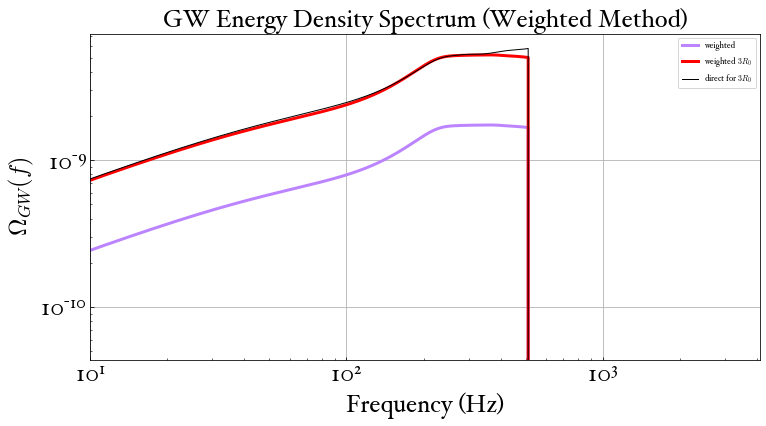

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(freqs_W, OmegaGW_W, color='#bc85ff', label='weighted', lw=3)
ax.loglog(freqs_W, OmegaGW_second_target_priors, color='r', label='weighted $3R_0$', lw=3)
for ii in range(1):
    ax.loglog(fs[ii], omgws[ii], color='#000000', alpha=1, label='direct for $3R_0$')
ax.set_title(r'GW Energy Density Spectrum (Weighted Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 4096)
ax.legend()
plt.show()